In [1]:
'''Bài 1. Sử dụng dữ liệu từ nguồn: https://www.kaggle.com/competitions/titanic/data
Yêu cầu:
+ Đối với cột age, thay vì chỉ điền giá trị trung bình hoặc trung vị, xây dựng một mô hình hồi quy tuyến tính
(Linear Regression) để dự đoán giá trị thiếu dựa trên các đặc trưng khác như pclass, sex, sibsp, và parch.
+ Đối với cột embarked, sử dụng thuật toán K-Nearest Neighbors (KNN) để điền giá trị thiếu dựa trên các đặc trưng liên quan.
+ Xử lý cột cabin (thường có nhiều giá trị thiếu): trích xuất thông tin từ ký tự đầu tiên của cabin (ví dụ: 'C', 'B') để tạo cột mới deck,
sau đó mã hóa cột này.
+ Tạo cột family_size như bài gốc (tổng sibsp + parch + 1).
+ Tạo cột is_alone (1 nếu hành khách đi một mình, 0 nếu đi cùng gia đình).
+ Trích xuất danh xưng (title) từ cột name (ví dụ: Mr, Mrs, Miss) và tạo cột title. Gộp các danh xưng hiếm (như Dr, Rev) thành nhóm "Rare".
+ Tạo cột fare_per_person bằng cách chia fare cho family_size để thể hiện giá vé trung bình mỗi người.
+ Vẽ biểu đồ boxplot để kiểm tra phân phối của fare_per_person theo pclass và survived.
+ Sử dụng kiểm định thống kê (ví dụ: t-test hoặc ANOVA) để kiểm tra xem fare_per_person có khác biệt đáng kể giữa các nhóm survived (sống sót hay không).
+ Xây dựng một pipeline xử lý dữ liệu (sử dụng sklearn.pipeline) để tự động hóa quá trình làm sạch, mã hóa, và chuẩn hóa dữ liệu.
+ Huấn luyện mô hình Random Forest để dự đoán survived dựa trên các đặc trưng đã xử lý và tạo mới.
+ Sử dụng Grid Search hoặc Random Search để tối ưu hóa siêu tham số của mô hình (ví dụ: n_estimators, max_depth).
+ Đánh giá mô hình bằng cross-validation (5-fold) và báo cáo các chỉ số: accuracy, precision, recall, F1-score, và ROC-AUC.
+ Tạo biểu đồ feature importance để xác định các đặc trưng quan trọng nhất ảnh hưởng đến khả năng sống sót.'''


'Bài 1. Sử dụng dữ liệu từ nguồn: https://www.kaggle.com/competitions/titanic/data\nYêu cầu:\n+ Đối với cột age, thay vì chỉ điền giá trị trung bình hoặc trung vị, xây dựng một mô hình hồi quy tuyến tính\n(Linear Regression) để dự đoán giá trị thiếu dựa trên các đặc trưng khác như pclass, sex, sibsp, và parch.\n+ Đối với cột embarked, sử dụng thuật toán K-Nearest Neighbors (KNN) để điền giá trị thiếu dựa trên các đặc trưng liên quan.\n+ Xử lý cột cabin (thường có nhiều giá trị thiếu): trích xuất thông tin từ ký tự đầu tiên của cabin (ví dụ: \'C\', \'B\') để tạo cột mới deck,\nsau đó mã hóa cột này.\n+ Tạo cột family_size như bài gốc (tổng sibsp + parch + 1).\n+ Tạo cột is_alone (1 nếu hành khách đi một mình, 0 nếu đi cùng gia đình).\n+ Trích xuất danh xưng (title) từ cột name (ví dụ: Mr, Mrs, Miss) và tạo cột title. Gộp các danh xưng hiếm (như Dr, Rev) thành nhóm "Rare".\n+ Tạo cột fare_per_person bằng cách chia fare cho family_size để thể hiện giá vé trung bình mỗi người.\n+ Vẽ biểu đ

In [44]:
import pandas as pd
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer
from sklearn.impute import SimpleImputer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, cross_validate
from sklearn.metrics import classification_report, roc_auc_score, RocCurveDisplay
import matplotlib.pyplot as plt
import seaborn as sns



train_data = pd.read_csv(r'train.csv')
test_data = pd.read_csv(r'test.csv')

In [17]:
# 1. Đối với cột age, thay vì chỉ điền giá trị trung bình hoặc trung vị, xây dựng một mô hình hồi quy tuyến tính
# (Linear Regression) để dự đoán giá trị thiếu dựa trên các đặc trưng khác như pclass, sex, sibsp, và parch.
features = ['Age', 'Pclass', 'Sex', 'SibSp', 'Parch']
data = train_data[features].copy()

data['Sex'] = data['Sex'].map({'male': 0, 'female': 1})

known_age = data[data['Age'].notna()]
unknown_age = data[data['Age'].isna()]

X = known_age.drop('Age', axis = 1)
y = known_age['Age']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = LinearRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse:.2f}')
print(f'Model score (R^2): {model.score(X_test, y_test): .2f}')

if not unknown_age.empty:
    X_missing = unknown_age.drop('Age', axis = 1)
    predicted_age = model.predict(X_missing)
    train_data.loc[train_data['Age'].isna(), 'Age'] = predicted_age

print(f"Số giá trị còn thiếu trong Age: {train_data['Age'].isna().sum}")

Mean Squared Error: 131.28
Model score (R^2):  0.26
Số giá trị còn thiếu trong Age: <bound method Series.sum of 0      False
1      False
2      False
3      False
4      False
       ...  
886    False
887    False
888    False
889    False
890    False
Name: Age, Length: 891, dtype: bool>


In [24]:
# Đọc dữ liệu
train_data = pd.read_csv('train.csv')

# Các đặc trưng liên quan để dự đoán Embarked
features = ['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked']
data = train_data[features].copy()

# Chuyển đổi giới tính thành số
data['Sex'] = data['Sex'].map({'male': 0, 'female': 1})

# Xử lý giá trị thiếu ở các cột số (Age, Fare)
num_cols = ['Age', 'Fare']
imputer = SimpleImputer(strategy='mean')
data[num_cols] = imputer.fit_transform(data[num_cols])

# Mã hóa cột Embarked tạm thời để làm nhãn
le = LabelEncoder()
data['Embarked_encoded'] = le.fit_transform(data['Embarked'].astype(str))

# Dữ liệu có Embarked (dùng để huấn luyện)
known = data[data['Embarked'].notna()]

# Dữ liệu thiếu Embarked (cần dự đoán)
unknown = data[data['Embarked'].isna()]

X_train = known.drop(['Embarked', 'Embarked_encoded'], axis=1)
y_train = known['Embarked_encoded']

# Chuẩn hóa dữ liệu
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

# Huấn luyện mô hình KNN
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train_scaled, y_train)

if not unknown.empty:
    X_test = unknown.drop(['Embarked', 'Embarked_encoded'], axis=1)
    X_test_scaled = scaler.transform(X_test)

    # Dự đoán giá trị mã hóa
    y_pred_encoded = knn.predict(X_test_scaled)

    # Chuyển về nhãn ban đầu
    y_pred_label = le.inverse_transform(y_pred_encoded)

    # Gán lại vào bản gốc
    train_data.loc[train_data['Embarked'].isna(), 'Embarked'] = y_pred_label

print(f"Số giá trị thiếu trong cột 'Embarked' sau khi điền: {train_data['Embarked'].isna().sum()}")



Số giá trị thiếu trong cột 'Embarked' sau khi điền: 0


In [ ]:
'''3. Xử lý cột cabin (thường có nhiều giá trị thiếu): trích xuất thông tin từ ký tự đầu tiên của cabin (ví dụ: 'C', 'B') để tạo cột mới deck,
sau đó mã hóa cột này.'''

#
train_data['Deck'] = train_data['Cabin'].str[0]
print('Phân phối các Deck trước khi xử lý')
print(train_data['Deck'].value_counts(dropna=False))

#Xử lý giá trị đặc biệt
train_data['Deck'] = train_data['Deck'].fillna('U')
train_data['Deck'] = train_data['Deck'].apply(lambda x: x if x.isalpha() else 'U')

print("Phân phối các Deck sau khi xử lý:")
print(train_data['Deck'].value_counts())

# Tạo biến giả (dummy variables)
deck_dummies = pd.get_dummies(train_data['Deck'], prefix='Deck')

# Ghép vào DataFrame gốc
train_data = pd.concat([train_data, deck_dummies], axis=1)

# Hiển thị kết quả
print("\nKết quả One-Hot Encoding:")
print(train_data.filter(like='Deck_').head())

# Phân tích tỷ lệ sống sót theo Deck
if 'Survived' in train_data.columns:
    deck_survival = train_data.groupby('Deck')['Survived'].mean().sort_values(ascending=False)
    print("\nTỷ lệ sống sót theo Deck:")
    print(deck_survival)

Family size:
0      2
1      2
2      1
3      2
4      1
      ..
886    1
887    1
888    4
889    1
890    1
Name: family_size, Length: 891, dtype: int64
Is alone: 
0      0
1      0
2      1
3      0
4      1
      ..
886    1
887    1
888    0
889    1
890    1
Name: is_alone, Length: 891, dtype: int64
Title:
0        Mr
1       Mrs
2      Miss
3       Mrs
4        Mr
       ... 
886    Rare
887    Miss
888    Miss
889      Mr
890      Mr
Name: Title, Length: 891, dtype: object
Fare per person
      Fare  family_size  fare_per_person
0   7.2500            2          3.62500
1  71.2833            2         35.64165
2   7.9250            1          7.92500
3  53.1000            2         26.55000
4   8.0500            1          8.05000


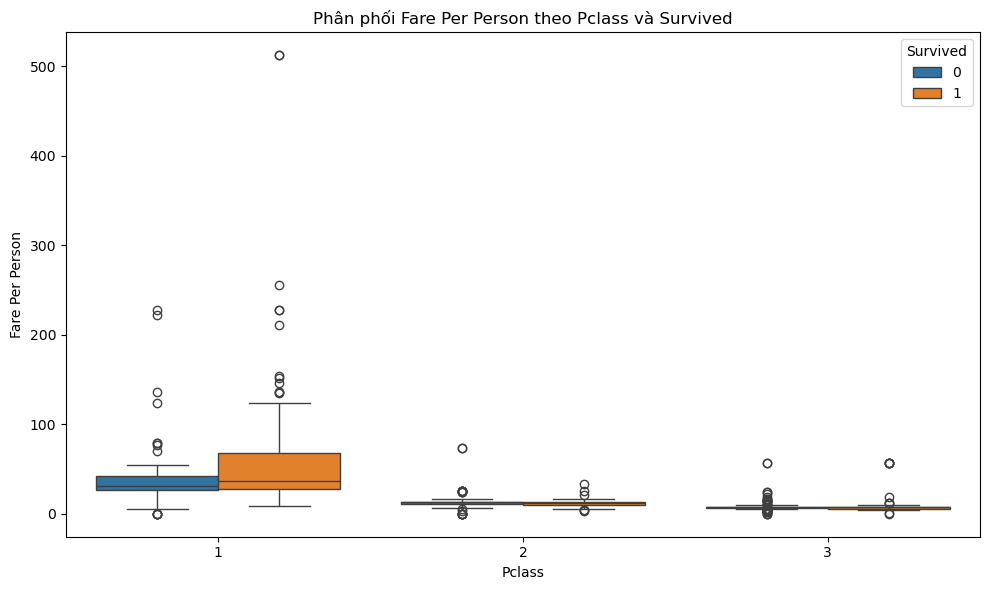

T-statistic: 5.6683
P-value: 0.0000


In [41]:
'''Tạo cột family_size như bài gốc (tổng sibsp + parch + 1).
Tạo cột is_alone (1 nếu hành khách đi một mình, 0 nếu đi cùng gia đình).
Trích xuất danh xưng (title) từ cột name (ví dụ: Mr, Mrs, Miss) và tạo cột title. Gộp các danh xưng hiếm (như Dr, Rev) thành nhóm "Rare".
Tạo cột fare_per_person bằng cách chia fare cho family_size để thể hiện giá vé trung bình mỗi người.
Vẽ biểu đồ boxplot để kiểm tra phân phối của fare_per_person theo pclass và survived.
Sử dụng kiểm định thống kê (ví dụ: t-test hoặc ANOVA) để kiểm tra xem fare_per_person có khác biệt đáng kể giữa các nhóm survived (sống sót hay không).
'''

#4
train_data['family_size'] = train_data['SibSp'] + train_data['Parch'] + 1
print('Family size:')
print(train_data['family_size'])

#5
train_data['is_alone'] = train_data['family_size'].apply(lambda x: 1 if x == 1 else 0)
print('Is alone: ')
print(train_data['is_alone'])

#6
# Sử dụng regex để trích xuất danh xưng (title) từ tên
train_data['Title'] = train_data['Name'].str.extract(r',\s*([^\.]*)\.', expand=False)
title_counts = train_data['Title'].value_counts()
rare_titles = title_counts[title_counts < 10].index
train_data['Title'] = train_data['Title'].replace(rare_titles, 'Rare')
print('Title:')
print(train_data['Title'])

#7
train_data['fare_per_person'] = train_data['Fare'] / train_data['family_size']
print('Fare per person')
print(train_data[['Fare', 'family_size', 'fare_per_person']].head())

#8
plt.figure(figsize=(10, 6))
sns.boxplot(x='Pclass', y='fare_per_person', hue='Survived', data=train_data)
plt.title('Phân phối Fare Per Person theo Pclass và Survived')
plt.ylabel('Fare Per Person')
plt.xlabel('Pclass')
plt.legend(title='Survived', loc='upper right')
plt.tight_layout()
plt.show()

#9
# Tách dữ liệu theo nhóm Survived
fare_survived = train_data[train_data['Survived'] == 1]['fare_per_person'].dropna()
fare_not_survived = train_data[train_data['Survived'] == 0]['fare_per_person'].dropna()
t_stat, p_value = ttest_ind(fare_survived, fare_not_survived, equal_var=False)
print(f"T-statistic: {t_stat:.4f}")
print(f"P-value: {p_value:.4f}")


In [43]:
'''+ Xây dựng một pipeline xử lý dữ liệu (sử dụng sklearn.pipeline) để tự động hóa quá trình làm sạch, mã hóa, và chuẩn hóa dữ liệu.
'''
class FeatureEngineer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.copy()
        
        # Tạo family_size, is_alone
        X['family_size'] = X['SibSp'] + X['Parch'] + 1
        X['is_alone'] = (X['family_size'] == 1).astype(int)
        
        # Tính fare_per_person
        X['fare_per_person'] = X['Fare'] / X['family_size']
        
        # Trích xuất Title
        X['Title'] = X['Name'].str.extract(r',\s*([^\.]*)\.', expand=False)
        
        # Gộp danh xưng hiếm
        rare_titles = ['Lady', 'Countess', 'Capt', 'Col', 'Don', 'Dr', 'Major', 
                       'Rev', 'Sir', 'Jonkheer', 'Dona']
        X['Title'] = X['Title'].replace(rare_titles, 'Rare')
        
        return X

numeric_features = ['Age', 'Fare', 'SibSp', 'Parch', 'family_size', 'fare_per_person']
categorical_features = ['Sex', 'Embarked', 'Title', 'is_alone']

# Xử lý cột số
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# Xử lý cột danh mục
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, numeric_features),
    ('cat', categorical_transformer, categorical_features)
])

full_pipeline = Pipeline(steps=[
    ('feature_engineering', FeatureEngineer()),
    ('preprocessing', preprocessor)
])

# Đảm bảo bạn đã đọc dữ liệu
train_data = pd.read_csv('train.csv')

# Áp dụng pipeline
X_preprocessed = full_pipeline.fit_transform(train_data)

# X_preprocessed là một ma trận numpy đã sẵn sàng cho mô hình ML
print(X_preprocessed.shape)




(891, 22)


Best parameters: {'classifier__max_depth': 5, 'classifier__min_samples_split': 5, 'classifier__n_estimators': 100}
Accuracy: 0.8294
Precision: 0.8070
Recall: 0.7306
F1: 0.7649
Roc_auc: 0.8667
              precision    recall  f1-score   support

           0       0.85      0.90      0.87       549
           1       0.82      0.74      0.78       342

    accuracy                           0.84       891
   macro avg       0.83      0.82      0.82       891
weighted avg       0.84      0.84      0.84       891

ROC-AUC: 0.9070


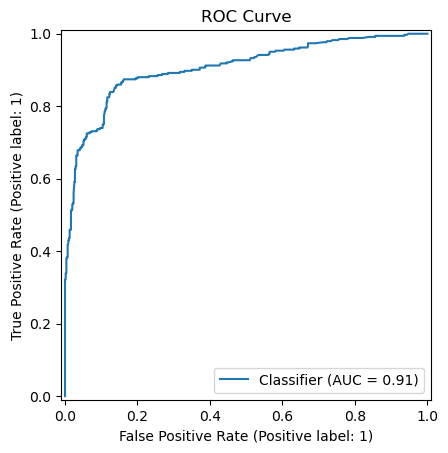

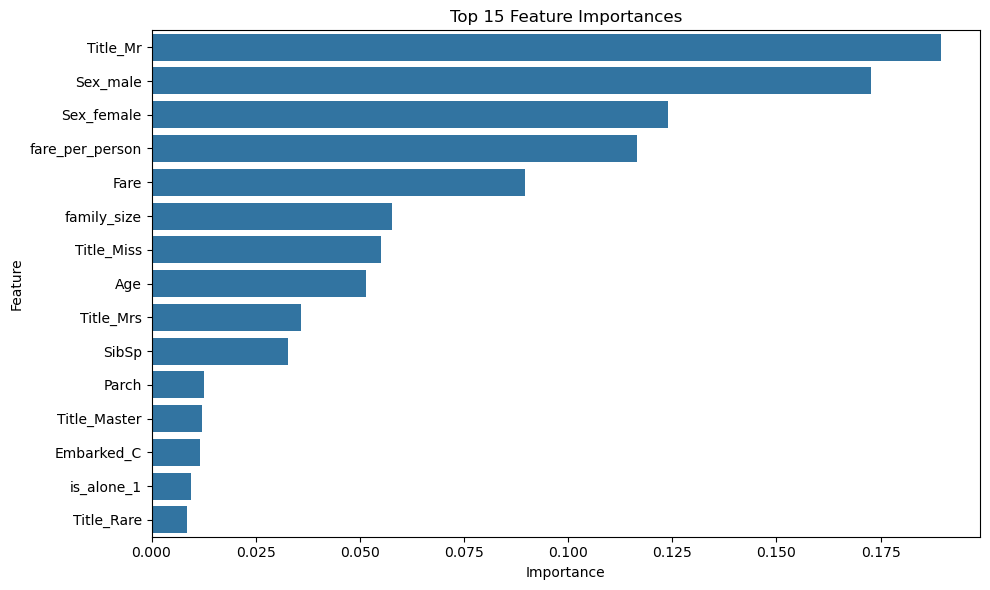

In [45]:
'''+ Huấn luyện mô hình Random Forest để dự đoán survived dựa trên các đặc trưng đã xử lý và tạo mới.
+ Sử dụng Grid Search hoặc Random Search để tối ưu hóa siêu tham số của mô hình (ví dụ: n_estimators, max_depth).
+ Đánh giá mô hình bằng cross-validation (5-fold) và báo cáo các chỉ số: accuracy, precision, recall, F1-score, và ROC-AUC.
+ Tạo biểu đồ feature importance để xác định các đặc trưng quan trọng nhất ảnh hưởng đến khả năng sống sót.'''

model_pipeline = Pipeline(steps=[
    ('feature_engineering', FeatureEngineer()),
    ('preprocessing', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42))
])

X = train_data.drop(columns=['Survived'])
y = train_data['Survived']

param_grid = {
    'classifier__n_estimators': [100, 200],
    'classifier__max_depth': [5, 10, None],
    'classifier__min_samples_split': [2, 5],
}

grid_search = GridSearchCV(model_pipeline, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X, y)

print(f"Best parameters: {grid_search.best_params_}")

scoring = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']
cv_results = cross_validate(grid_search.best_estimator_, X, y, cv=5, scoring=scoring)

for metric in scoring:
    mean_score = cv_results[f'test_{metric}'].mean()
    print(f"{metric.capitalize()}: {mean_score:.4f}")

# Dự đoán trên tập huấn luyện để demo báo cáo (nên dùng tập test nếu có)
y_pred = grid_search.predict(X)
y_proba = grid_search.predict_proba(X)[:, 1]

print(classification_report(y, y_pred))
print(f"ROC-AUC: {roc_auc_score(y, y_proba):.4f}")

# Vẽ ROC curve
RocCurveDisplay.from_predictions(y, y_proba)
plt.title("ROC Curve")
plt.show()

# Lấy tên cột sau khi one-hot
onehot_cols = grid_search.best_estimator_.named_steps['preprocessing'].transformers_[1][1]\
                    .named_steps['encoder'].get_feature_names_out(categorical_features)
all_features = numeric_features + list(onehot_cols)

# Lấy importances
importances = grid_search.best_estimator_.named_steps['classifier'].feature_importances_

# Tạo DataFrame
feat_imp_df = pd.DataFrame({'Feature': all_features, 'Importance': importances})
feat_imp_df = feat_imp_df.sort_values('Importance', ascending=False)

# Vẽ
plt.figure(figsize=(10, 6))
sns.barplot(data=feat_imp_df.head(15), x='Importance', y='Feature')
plt.title("Top 15 Feature Importances")
plt.tight_layout()
plt.show()
